# [How to train an object detection model with mmdetection](https://www.dlology.com/blog/how-to-train-an-object-detection-model-with-mmdetection/) | DLology blog

In [1]:
# You can add more model configs like below.
MODELS_CONFIG = {
    'faster_rcnn_r50_fpn_1x': {
        'config_file': 'configs/pascal_voc/faster_rcnn_r50_fpn_1x_voc0712.py'
    },
    'cascade_rcnn_r50_fpn_1x': {
        'config_file': 'configs/cascade_rcnn_r50_fpn_1x.py',
    },
    'retinanet_r50_fpn_1x': {
        'config_file': 'configs/retinanet_r50_fpn_1x.py',
    }
}

## Your settings

In [2]:
# TODO: change URL to your fork of my repository if necessary.
git_repo_url = 'https://github.com/svaditya/mmdetection_object_detection_demo.git'

# Pick the model you want to use
# Select a model in `MODELS_CONFIG`.
selected_model = 'faster_rcnn_r50_fpn_1x'  # 'cascade_rcnn_r50_fpn_1x'

# Total training epochs.
total_epochs = 8

# Name of the config file.
config_file = MODELS_CONFIG[selected_model]['config_file']

## Install Open MMLab Detection Toolbox
Restart the runtime if you have issue importing `mmdet` later on.


In [3]:
import os
from os.path import exists, join, basename, splitext

%cd /content
project_name = os.path.abspath(splitext(basename(git_repo_url))[0])
mmdetection_dir = os.path.join(project_name, "mmdetection")
if not exists(project_name):
    # clone "depth 1" will only get the latest copy of the relevant files.
    !git clone -q --recurse-submodules --depth 1 $git_repo_url
    print("Update mmdetection repo")
    !cd {mmdetection_dir} && git checkout master && git pull
    # dependencies
    !pip install -q mmcv terminaltables
    # build
    !cd {mmdetection_dir} && python setup.py install
    !pip install -r {os.path.join(mmdetection_dir, "requirements.txt")}


import sys
sys.path.append(mmdetection_dir)
import time
import matplotlib
import matplotlib.pylab as plt
plt.rcParams["axes.grid"] = False

/content


## Stash the repo if you want to re-modify `voc.py` and config file.

In [ ]:
# !cd {mmdetection_dir} && git config --global user.email "zcw607@gmail.com" && git config --global user.name "Tony607" && git stash

## Modify `voc.py`
### parse data classes

In [4]:
%cd {project_name}

/content/mmdetection_object_detection_demo


In [5]:
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET

In [6]:
anno_path = os.path.join(project_name, "data/VOC2007/Annotations")
voc_file = os.path.join(mmdetection_dir, "mmdet/datasets/voc.py")

In [7]:
classes_names = []
xml_list = []
for xml_file in glob.glob(anno_path + "/*.xml"):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    for member in root.findall("object"):
        classes_names.append(member[0].text)
classes_names = list(set(classes_names))
classes_names.sort()
classes_names

['address', 'brand', 'date', 'total']

In [8]:
import re

fname = voc_file
with open(fname) as f:
    s = f.read()
    s = re.sub('CLASSES = \(.*?\)',
               'CLASSES = ({})'.format(", ".join(["\'{}\'".format(name) for name in classes_names])), s, flags=re.S)
with open(fname, 'w') as f:
    f.write(s)
!cat {voc_file}

from mmdet.core import eval_map, eval_recalls
from .builder import DATASETS
from .xml_style import XMLDataset


@DATASETS.register_module()
class VOCDataset(XMLDataset):

    CLASSES = ('address', 'brand', 'date', 'total')

    def __init__(self, **kwargs):
        super(VOCDataset, self).__init__(**kwargs)
        if 'VOC2007' in self.img_prefix:
            self.year = 2007
        elif 'VOC2012' in self.img_prefix:
            self.year = 2012
        else:
            raise ValueError('Cannot infer dataset year from img_prefix')

    def evaluate(self,
                 results,
                 metric='mAP',
                 logger=None,
                 proposal_nums=(100, 300, 1000),
                 iou_thr=0.5,
                 scale_ranges=None):
        """Evaluate in VOC protocol.

        Args:
            results (list[list | tuple]): Testing results of the dataset.
            metric (str | list[str]): Metrics to be evaluated. Options are
                'mAP', 'recall'.


## Modify config file

In [9]:
import os
config_fname = os.path.join(project_name, 'mmdetection', config_file)

assert os.path.isfile(config_fname), '`{}` not exist'.format(config_fname)
config_fname

'/content/mmdetection_object_detection_demo/mmdetection/configs/pascal_voc/faster_rcnn_r50_fpn_1x_voc0712.py'

In [11]:
fname = config_fname
with open(fname) as f:
    s = f.read()
    work_dir = "/content/mmdetection_object_detection_demo/mmdetection/work_dirs/faster_rcnn_r50_fpn_1x_voc0712" #re.findall(r"work_dir = \'(.*?)\'", s)[0]
    # Update `num_classes` including `background` class.
    s = re.sub('num_classes=.*?,',
               'num_classes={},'.format(len(classes_names) + 1), s)
    s = re.sub('ann_file=.*?\],',
               "ann_file=data_root + 'VOC2007/ImageSets/Main/trainval.txt',", s, flags=re.S)
    s = re.sub('total_epochs = \d+',
               'total_epochs = {} #'.format(total_epochs), s)
    if "CocoDataset" in s:
        s = re.sub("dataset_type = 'CocoDataset'",
                   "dataset_type = 'VOCDataset'", s)
        s = re.sub("data_root = 'data/coco/'",
                   "data_root = 'data/VOCdevkit/'", s)
        s = re.sub("annotations/instances_train2017.json",
                   "VOC2007/ImageSets/Main/trainval.txt", s)
        s = re.sub("annotations/instances_val2017.json",
                   "VOC2007/ImageSets/Main/test.txt", s)
        s = re.sub("annotations/instances_val2017.json",
                   "VOC2007/ImageSets/Main/test.txt", s)
        s = re.sub("train2017", "VOC2007", s)
        s = re.sub("val2017", "VOC2007", s)
    else:
        s = re.sub('img_prefix=.*?\],',
                   "img_prefix=data_root + 'VOC2007/',".format(total_epochs), s)
with open(fname, 'w') as f:
    f.write(s)
!cat {config_fname}

_base_ = [
    '../_base_/models/faster_rcnn_r50_fpn.py', '../_base_/datasets/voc0712.py',
    '../_base_/default_runtime.py'
]
model = dict(roi_head=dict(bbox_head=dict(num_classes=20)))
# optimizer
optimizer = dict(type='SGD', lr=0.01, momentum=0.9, weight_decay=0.0001)
optimizer_config = dict(grad_clip=None)
# learning policy
# actual epoch = 3 * 3 = 9
lr_config = dict(policy='step', step=[3])
# runtime settings
total_epochs = 8 #  # actual epoch = 4 * 3 = 12


In [12]:
%cd {mmdetection_dir}
!python setup.py install

/content/mmdetection_object_detection_demo/mmdetection
running install
running bdist_egg
running egg_info
writing mmdet.egg-info/PKG-INFO
writing dependency_links to mmdet.egg-info/dependency_links.txt
writing requirements to mmdet.egg-info/requires.txt
writing top-level names to mmdet.egg-info/top_level.txt
writing manifest file 'mmdet.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
copying mmdet/version.py -> build/lib/mmdet
copying mmdet/datasets/voc.py -> build/lib/mmdet/datasets
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/mmdet
copying build/lib/mmdet/version.py -> build/bdist.linux-x86_64/egg/mmdet
creating build/bdist.linux-x86_64/egg/mmdet/apis
copying build/lib/mmdet/apis/inference.py -> build/bdist.linux-x86_64/egg/mmdet/apis
copying build/lib/mmdet/apis/__init__.py -> build/bdist.linux-x86_64/egg/mmdet/apis
copying build/lib/mmdet/apis/train.py -> build/bdist.linux-x86_64/egg/m

In [13]:
os.makedirs("data/VOCdevkit", exist_ok=True)
voc2007_dir = os.path.join(project_name, "data/VOC2007")
os.system("ln -s {} data/VOCdevkit".format(voc2007_dir))

0

In [18]:
!mkdir data/VOCdevkit/VOC2012 

In [19]:
!cp -r data/VOCdevkit/VOC2007/* data/VOCdevkit/VOC2012/

In [21]:
!python tools/train.py {config_fname}

2020-07-13 01:52:10,301 - mmdet - INFO - Environment info:
------------------------------------------------------------
sys.platform: linux
Python: 3.6.9 (default, Apr 18 2020, 01:56:04) [GCC 8.4.0]
CUDA available: True
CUDA_HOME: /usr/local/cuda
NVCC: Cuda compilation tools, release 10.1, V10.1.243
GPU 0: Tesla P100-PCIE-16GB
GCC: gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
PyTorch: 1.5.1+cu101
PyTorch compiling details: PyTorch built with:
  - GCC 7.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2019.0.5 Product Build 20190808 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v0.21.1 (Git Hash 7d2fd500bc78936d1d648ca713b901012f470dbc)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 10.1
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_61,code=sm_61;-gencode;arch=compute_70,code=sm_70;-gen

In [15]:
!pip install mmcv-full

     |████████████████████████████████| 235kB 4.1MB/s 
  Created wheel for mmcv-full: filename=mmcv_full-1.0.2-cp36-cp36m-linux_x86_64.whl size=16285819 sha256=31ab52f115537d63edc77eb107256ba95484831c74067a78eb5a1661c87b4e5e
  Stored in directory: /root/.cache/pip/wheels/60/a8/df/94b37c3935d4ef3035e66106787bcf0096a86a92ec77f9fe6f
Successfully built mmcv-full


In [22]:
checkpoint_file = os.path.join(mmdetection_dir, work_dir, "latest.pth")
assert os.path.isfile(
    checkpoint_file), '`{}` not exist'.format(checkpoint_file)
checkpoint_file

'/content/mmdetection_object_detection_demo/mmdetection/work_dirs/faster_rcnn_r50_fpn_1x_voc0712/latest.pth'

## Test predict

Turn down the `score_thr` if you think the model is missing any bbox.
Turn up the `score_thr` if you see too much overlapping bboxes with low scores.

In [24]:
import time
import matplotlib
import matplotlib.pylab as plt
plt.rcParams["axes.grid"] = False

import mmcv
from mmcv.runner import load_checkpoint
import mmcv.visualization.image as mmcv_image
# fix for colab


def imshow(img, win_name='', wait_time=0): plt.figure(
    figsize=(50, 50)); plt.imshow(img)


mmcv_image.imshow = imshow
from mmdet.models import build_detector
from mmdet.apis import inference_detector, show_result_pyplot, init_detector

/content/mmdetection_object_detection_demo/mmdetection


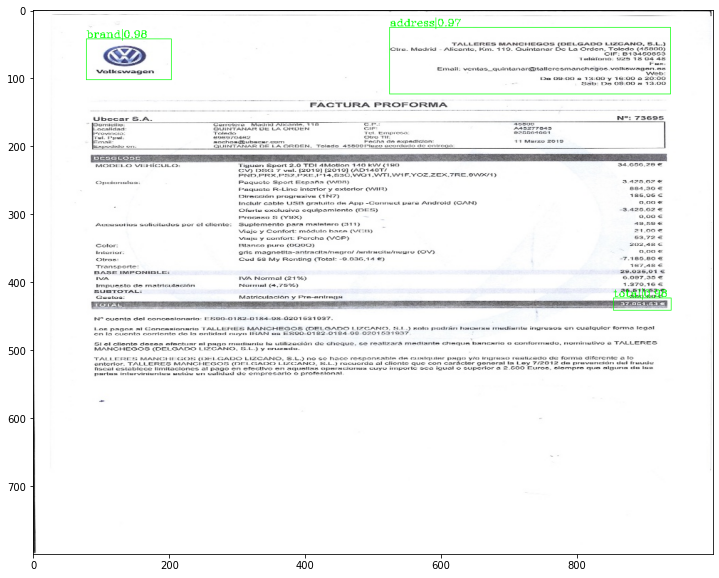

In [27]:
%cd {mmdetection_dir}

score_thr = 0.8

# build the model from a config file and a checkpoint file
model = init_detector(config_fname, checkpoint_file)

# test a single image and show the results
img = 'data/VOCdevkit/VOC2007/JPEGImages/15.jpg'
result = inference_detector(model, img)
#show_result(img, result, model.CLASSES,
#            score_thr=score_thr, out_file="result.jpg")
show_result_pyplot(model, img, result, score_thr)

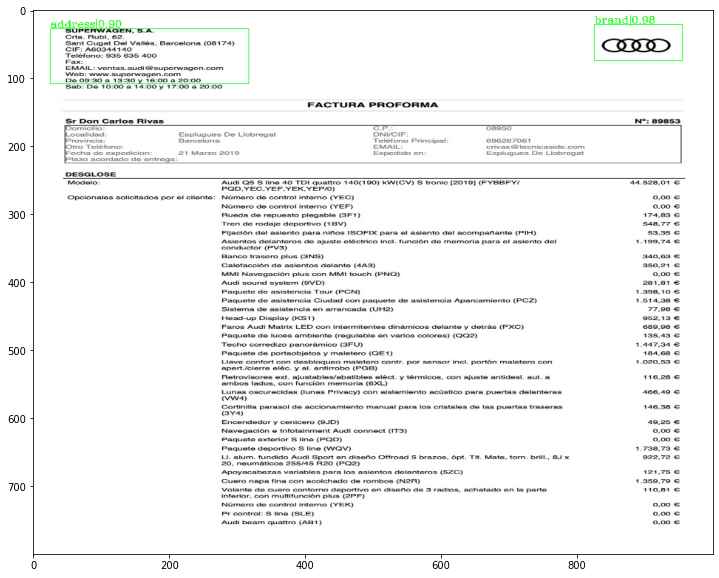

In [28]:
# test a single image and show the results
img = 'data/VOCdevkit/VOC2007/JPEGImages/7.jpg'
result = inference_detector(model, img)
#show_result(img, result, model.CLASSES,
#            score_thr=score_thr, out_file="result.jpg")
show_result_pyplot(model, img, result, score_thr)

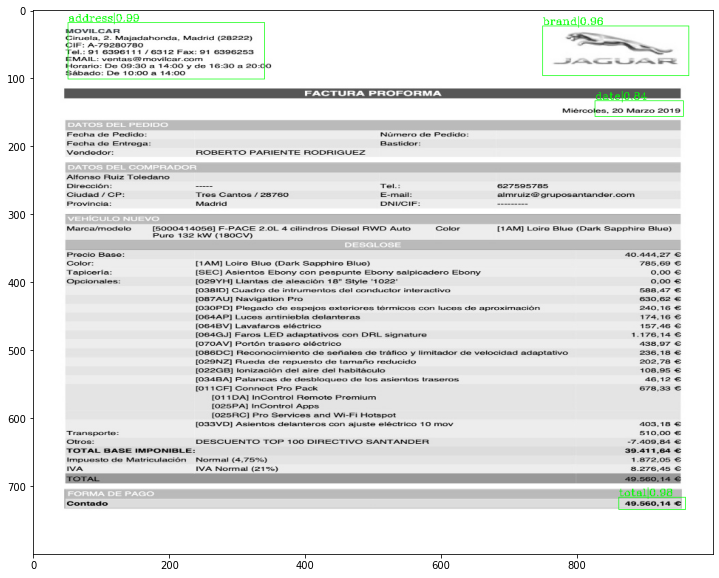

In [29]:
# test a single image and show the results
img = 'data/VOCdevkit/VOC2007/JPEGImages/9.jpg'
result = inference_detector(model, img)
#show_result(img, result, model.CLASSES,
#            score_thr=score_thr, out_file="result.jpg")
show_result_pyplot(model, img, result, score_thr)

In [30]:
!ls

build	 demo	 docs	  mmdet.egg-info  requirements	    setup.py  work_dirs
configs  dist	 LICENSE  pytest.ini	  requirements.txt  tests
data	 docker  mmdet	  README.md	  resources	    tools


In [31]:
result

[array([[5.1409534e+01, 1.8440041e+01, 3.4009253e+02, 1.0106909e+02,
         9.8855501e-01],
        [7.6811310e+02, 4.1052608e+01, 9.4673486e+02, 8.9407631e+01,
         3.8261986e-01],
        [7.5727521e+02, 2.1768713e+01, 9.5907538e+02, 1.1732379e+02,
         1.8946792e-01],
        [4.5895916e+01, 3.7470398e+00, 2.6039334e+02, 1.4055997e+02,
         1.4682844e-01],
        [0.0000000e+00, 1.4420319e+01, 5.1022269e+02, 1.3173845e+02,
         9.3527064e-02]], dtype=float32),
 array([[7.49218506e+02, 2.34199142e+01, 9.64112732e+02, 9.64181213e+01,
         9.59205091e-01],
        [8.07681824e+02, 3.62920837e+01, 9.28232117e+02, 5.97487984e+01,
         1.31466985e-01],
        [8.39346436e+02, 3.23769493e+01, 9.62074463e+02, 1.17086914e+02,
         7.98168480e-02]], dtype=float32),
 array([[8.2664917e+02, 1.3325157e+02, 9.5637555e+02, 1.5699187e+02,
         8.3682972e-01],
        [7.8368237e+02, 1.2923935e+02, 9.6179596e+02, 1.6469655e+02,
         2.5510567e-01],
        [7.